#Load Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.listdir('/content/drive/My Drive/gro_homework/')

['2022 Gro DS Eng Summer Internship Take Home Instructions.pdf',
 'Daily Precipitation.csv',
 'Daily Soil Mositure.csv',
 'Daily Temperature.csv',
 'Eight Day NDVI.csv',
 'predicted_production_qty.csv',
 'Production Quantity.csv']

In [ ]:
%cd /content/drive/My Drive/gro_homework/
df_daily_pre=pd.read_csv('Daily Precipitation.csv', parse_dates=['start_date','end_date'])
df_daily_soil=pd.read_csv('Daily Soil Mositure.csv', parse_dates=['start_date','end_date'])
df_daily_temp=pd.read_csv('Daily Temperature.csv', parse_dates=['start_date','end_date'])
df_eight_day=pd.read_csv('Eight Day NDVI.csv', parse_dates=['start_date','end_date'])
df_pred_prod_quan=pd.read_csv('predicted_production_qty.csv',parse_dates=['start_date','end_date'])
df_prod_quan=pd.read_csv('Production Quantity.csv',parse_dates=['start_date','end_date'])

/content/drive/My Drive/gro_homework


#Have a look on dataset

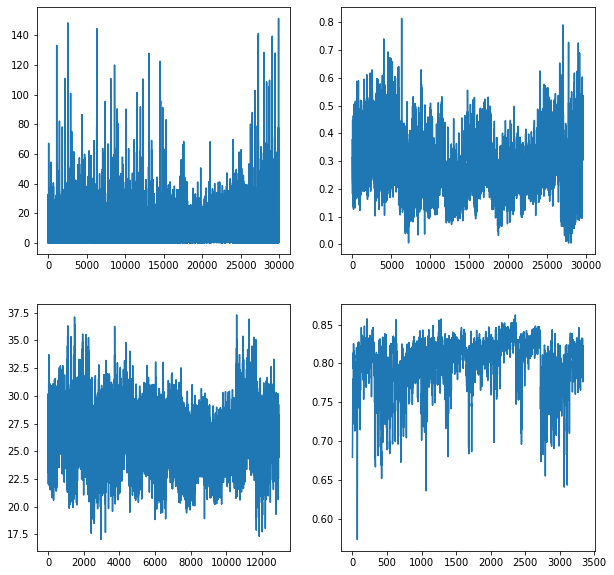

In [ ]:
fig,ax=plt.subplots(2,2, figsize=(10,10))

ax[0,0].plot(df_daily_pre.precip)

ax[0,1].plot(df_daily_soil.smos)

ax[1,0].plot(df_daily_temp.temp)

ax[1,1].plot(df_eight_day.ndvi)

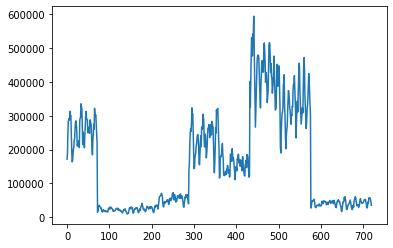

In [ ]:
plt.plot(df_prod_quan[['prod']])

#Preprocessing Datasets

In [ ]:
df_daily_pre_mean=df_daily_pre.groupby('region_id').resample(('M'),on='start_date').mean()
df_daily_soil_mean=df_daily_soil.groupby('region_id').resample(('M'),on='start_date').mean()
df_daily_temp_mean=df_daily_temp.groupby('region_id').resample(('M'),on='start_date').mean()
df_eight_day_mean=df_eight_day.groupby('region_id').resample(('M'),on='start_date').mean()

In [ ]:
df_daily_pre_mean=df_daily_pre_mean['precip'].reset_index()
df_daily_soil_mean=df_daily_soil_mean['smos'].reset_index()
df_daily_temp_mean=df_daily_temp_mean['temp'].reset_index()
df_eight_day_mean=df_eight_day_mean['ndvi'].reset_index()

In [ ]:
df_all=pd.merge(df_daily_pre_mean,df_daily_soil_mean, left_on=(['start_date','region_id']), right_on=(['start_date','region_id']))
df_all=pd.merge(df_all,df_daily_temp_mean, left_on=(['start_date','region_id']), right_on=(['start_date','region_id']))
df_all=pd.merge(df_all,df_eight_day_mean, left_on=(['start_date','region_id']), right_on=(['start_date','region_id']))
df_all=pd.merge(df_all,df_prod_quan.iloc[:,1:4], left_on=(['start_date','region_id']), right_on=(['end_date','region_id']))

##Fill NAs

In [ ]:
df_all.ndvi.fillna(df_all.ndvi.mean(), inplace=True)

## Drop duplicates

In [ ]:
sum(df_all.duplicated(keep='first'))# no duplicates

0

In [ ]:
'''from statsmodels.stats.outliers_influence import variance_inflation_factor
vif=[variance_inflation_factor(df_all[['precip','smos','temp','ndvi']].values, i) for i in range(4)]
vif'''

"from statsmodels.stats.outliers_influence import variance_inflation_factor\nvif=[variance_inflation_factor(df_all[['precip','smos','temp','ndvi']].values, i) for i in range(4)]\nvif"

##Preprocess categorical variables

In [ ]:
df_all['region_id']=pd.Categorical(df_all.region_id)

In [ ]:
#df_all['month']=pd.Categorical(df_all['start_date'].dt.month)

In [ ]:
df_all=pd.get_dummies(df_all)
df_all.head()

,start_date,precip,smos,temp,ndvi,end_date,prod,region_id_93,region_id_94,region_id_95,region_id_97,region_id_98,region_id_99,region_id_102,region_id_103,region_id_104,region_id_105
0,2015-01-31 00:00:00+00:00,4.394452,0.318552,25.003593,0.761228,2015-01-31 00:00:00+00:00,171725,1,0,0,0,0,0,0,0,0,0
1,2015-02-28 00:00:00+00:00,1.206137,0.291452,26.807568,0.758957,2015-02-28 00:00:00+00:00,188325,1,0,0,0,0,0,0,0,0,0
2,2015-03-31 00:00:00+00:00,3.454652,0.251969,26.954109,0.752754,2015-03-31 00:00:00+00:00,247856,1,0,0,0,0,0,0,0,0,0
3,2015-04-30 00:00:00+00:00,10.466472,0.248915,26.948865,0.785057,2015-04-30 00:00:00+00:00,282791,1,0,0,0,0,0,0,0,0,0
4,2015-05-31 00:00:00+00:00,9.007986,0.280602,25.405121,0.805262,2015-05-31 00:00:00+00:00,291057,1,0,0,0,0,0,0,0,0,0


# Train a Model

##Train/Test Split

In [ ]:
X=df_all[['precip','smos','temp','ndvi','region_id_93','region_id_94','region_id_95','region_id_97','region_id_98','region_id_99','region_id_102','region_id_103','region_id_104','region_id_105']]
#X=df_all.iloc[:,list(range(1,5))+list(range(7,29))]
Y=df_all[['prod']]
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25, random_state=123)

##Function to calculate MAPE

In [ ]:
def mape(actual, pred):
  return np.mean(np.abs((actual - pred) / actual))

##Model fitting

In [ ]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X_train, Y_train)
Y_pred=lr.predict(X_test)
mape(Y_test, Y_pred)

prod    0.213034
dtype: float64

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

gbc=GradientBoostingRegressor()
gbc.fit(X_train, Y_train)
Y_pred_gbc=gbc.predict(X_test).reshape(-1,1)

print(mape(Y_train,gbc.predict(X_train).reshape(-1,1)))
print(mape(Y_test,Y_pred_gbc))
print(r2_score(Y_pred_gbc, Y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


prod    0.15081
dtype: float64
prod    0.166051
dtype: float64
0.954450986456809


In [ ]:
import xgboost
xgb=xgboost.XGBRegressor()
xgb.fit(X_train,Y_train)
Y_pred_xgb=xgb.predict(X_test).reshape(-1,1)

print(mape(Y_train,xgb.predict(X_train).reshape(-1,1)))
print(mape(Y_test,Y_pred_xgb))
print(r2_score(Y_pred_xgb, Y_test))

[20:46:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
prod    0.161258
dtype: float64
prod    0.18683
dtype: float64
0.9531664359481088


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=50, max_features='auto')
rf.fit(X_train,Y_train.to_numpy().ravel())
Y_pred_rf=rf.predict(X_test).reshape(-1,1)

print(mape(Y_train,rf.predict(X_train).reshape(-1,1)))
print(mape(Y_test,Y_pred_rf))
print(r2_score(Y_pred_rf, Y_test))

prod    0.058358
dtype: float64
prod    0.155368
dtype: float64
0.9634174762314784


In [ ]:
from sklearn.model_selection import GridSearchCV
params={'n_estimators':[30,50,100,200],
            'max_features' : ["auto", "sqrt", "log2"],
            }
gscv=GridSearchCV(RandomForestRegressor(),
                  param_grid=params,
                  cv=3,
                  refit=True)
gscv.fit(X_train,Y_train.to_numpy().ravel())
print(gscv.best_params_)

{'max_features': 'auto', 'n_estimators': 50}


In [ ]:
df_pred_prod_quan

,start_date,end_date,prod,region_id
0,2021-01-01 00:00:00+00:00,2021-01-31 00:00:00+00:00,NaN,93
1,2021-02-01 00:00:00+00:00,2021-02-28 00:00:00+00:00,NaN,93
2,2021-03-01 00:00:00+00:00,2021-03-31 00:00:00+00:00,NaN,93
3,2021-04-01 00:00:00+00:00,2021-04-30 00:00:00+00:00,NaN,93
4,2021-05-01 00:00:00+00:00,2021-05-31 00:00:00+00:00,NaN,93
...,...,...,...,...
115,2021-08-01 00:00:00+00:00,2021-08-31 00:00:00+00:00,NaN,105
116,2021-09-01 00:00:00+00:00,2021-09-30 00:00:00+00:00,NaN,105
117,2021-10-01 00:00:00+00:00,2021-10-31 00:00:00+00:00,NaN,105
118,2021-11-01 00:00:00+00:00,2021-11-30 00:00:00+00:00,NaN,105


#Make Predictions

In [ ]:
df_test=pd.merge(df_pred_prod_quan.iloc[:,1:4],df_daily_pre_mean, left_on=(['end_date','region_id']), right_on=(['start_date','region_id']))
df_test=pd.merge(df_test,df_daily_soil_mean, left_on=(['start_date','region_id']), right_on=(['start_date','region_id']))
df_test=pd.merge(df_test,df_daily_temp_mean, left_on=(['start_date','region_id']), right_on=(['start_date','region_id']))
df_test=pd.merge(df_test,df_eight_day_mean, left_on=(['start_date','region_id']), right_on=(['start_date','region_id']))

In [ ]:
df_test['region_id']=pd.Categorical(df_test.region_id)
df_test=pd.get_dummies(df_test)

In [ ]:
df_test.head()

,end_date,prod,start_date,precip,smos,temp,ndvi,region_id_93,region_id_94,region_id_95,region_id_97,region_id_98,region_id_99,region_id_102,region_id_103,region_id_104,region_id_105
0,2021-01-31 00:00:00+00:00,NaN,2021-01-31 00:00:00+00:00,15.395451,0.430121,25.093076,0.792559,1,0,0,0,0,0,0,0,0,0
1,2021-02-28 00:00:00+00:00,NaN,2021-02-28 00:00:00+00:00,0.478108,0.376494,26.897011,0.768814,1,0,0,0,0,0,0,0,0,0
2,2021-03-31 00:00:00+00:00,NaN,2021-03-31 00:00:00+00:00,6.838074,0.321724,28.251589,0.785876,1,0,0,0,0,0,0,0,0,0
3,2021-04-30 00:00:00+00:00,NaN,2021-04-30 00:00:00+00:00,8.185650,0.372365,27.924892,0.818826,1,0,0,0,0,0,0,0,0,0
4,2021-05-31 00:00:00+00:00,NaN,2021-05-31 00:00:00+00:00,8.845651,0.350557,26.930918,0.825478,1,0,0,0,0,0,0,0,0,0


In [ ]:
X_pred_test=df_test[['precip','smos','temp','ndvi','region_id_93','region_id_94','region_id_95','region_id_97',
                    'region_id_98','region_id_99','region_id_102','region_id_103','region_id_104','region_id_105']]


In [ ]:
df_test['prod']=gbc.predict(X_pred_test)
df_test.head()

,end_date,prod,start_date,precip,smos,temp,ndvi,region_id_93,region_id_94,region_id_95,region_id_97,region_id_98,region_id_99,region_id_102,region_id_103,region_id_104,region_id_105
0,2021-01-31 00:00:00+00:00,227425.517802,2021-01-31 00:00:00+00:00,15.395451,0.430121,25.093076,0.792559,1,0,0,0,0,0,0,0,0,0
1,2021-02-28 00:00:00+00:00,222178.903556,2021-02-28 00:00:00+00:00,0.478108,0.376494,26.897011,0.768814,1,0,0,0,0,0,0,0,0,0
2,2021-03-31 00:00:00+00:00,259218.928867,2021-03-31 00:00:00+00:00,6.838074,0.321724,28.251589,0.785876,1,0,0,0,0,0,0,0,0,0
3,2021-04-30 00:00:00+00:00,250711.847830,2021-04-30 00:00:00+00:00,8.185650,0.372365,27.924892,0.818826,1,0,0,0,0,0,0,0,0,0
4,2021-05-31 00:00:00+00:00,256426.766329,2021-05-31 00:00:00+00:00,8.845651,0.350557,26.930918,0.825478,1,0,0,0,0,0,0,0,0,0


##Write CSV file

In [ ]:
df_pred_prod_quan['prod']=gbc.predict(X_pred_test)
df_pred_prod_quan

,start_date,end_date,prod,region_id
0,2021-01-01 00:00:00+00:00,2021-01-31 00:00:00+00:00,227425.517802,93
1,2021-02-01 00:00:00+00:00,2021-02-28 00:00:00+00:00,222178.903556,93
2,2021-03-01 00:00:00+00:00,2021-03-31 00:00:00+00:00,259218.928867,93
3,2021-04-01 00:00:00+00:00,2021-04-30 00:00:00+00:00,250711.847830,93
4,2021-05-01 00:00:00+00:00,2021-05-31 00:00:00+00:00,256426.766329,93
...,...,...,...,...
115,2021-08-01 00:00:00+00:00,2021-08-31 00:00:00+00:00,54976.747522,105
116,2021-09-01 00:00:00+00:00,2021-09-30 00:00:00+00:00,55650.321680,105
117,2021-10-01 00:00:00+00:00,2021-10-31 00:00:00+00:00,52136.502553,105
118,2021-11-01 00:00:00+00:00,2021-11-30 00:00:00+00:00,46108.682336,105


In [ ]:
df_pred_prod_quan.to_csv('dx2219@columbia.edu.csv')